# Introduction to problem solving for data
This kernel hopes to outline techniques to creatively fill missing values, transform data for statistical analysis, blend technologies, and deliver a model for estimating results.

## Document Outline
1. Import Python packages needed and data
2. Review the data and identify missing data
3. Clean key data by filling estimates for missing data
4. Extract modified training data and visualize in shinyapps.io
5. Build on insights from visuals to train a basic machine learning model
7. Test data and submit results

## Import Python packages needed and data

In [1]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/')
from titanic import *

In [2]:
# import packages needed as a separate cell. It makes it easy to add and rerun in the future as you progress through the project.

import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt


In [3]:
test_data()

it works, oh yeah!


In [6]:
# importing data sets from kernel 

train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

## Review the data and identify missing data

In [3]:
# displaying shape of data and column names
# as you can see the test data is missing the survival rate, which is what we need to eventually estimate on the test data

print("Train Shape:   " + str(train.shape))
print("Test Shape:    " + str(test.shape))
print("Train Columns: " + str(train.columns))
print("Test Columns:  " + str(test.columns))

Train Shape:   (891, 12)
Test Shape:    (418, 11)
Train Columns: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Test Columns:  Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [4]:
# displaying the first five rows of the training data to see what is in each column

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
train.loc[train['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Count
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,1
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,1
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,1
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,1
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,1
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,1
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,1
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,1
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,1


In [11]:
train.sort_values(by=['Fare'], ascending=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
...,...,...,...,...,...,...,...,...,...,...,...,...
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S
732,733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S


In [13]:
train['Count'] = 1

In [35]:
bins = [0, 30, 40, 50, 60, 100, 200, 300, 1000]
train['fare_bins'] = pd.cut(train['Fare'], bins)

In [38]:
fare_bins = train.fare_bins.value_counts()

fb = pd.DataFrame(fare_bins)

In [44]:
fb.sort_index(inplace=True)

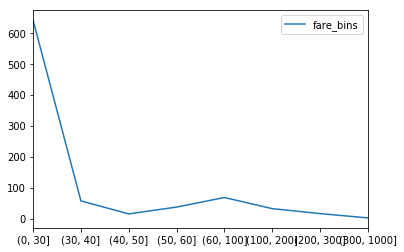

In [48]:
fb.plot()

In [12]:
train.loc[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [96]:
cb_rev = train.loc[train['Cabin'].notnull()]
cb_rev.loc[cb_rev['Cabin'].notnull(), 'Cabin'] = cb_rev['Cabin'].str[0].copy()
cb_rev.sort_values(by=['Cabin'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Count,fare_bins
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A,S,1,"(50, 60]"
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A,C,1,"(30, 40]"
209,210,1,1,"Blank, Mr. Henry",male,40.0,0,0,112277,31.0000,A,C,1,"(30, 40]"
445,446,1,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A,S,1,"(60, 100]"
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A,C,1,"(30, 40]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,206,0,3,"Strom, Miss. Telma Matilda",female,2.0,0,1,347054,10.4625,G,S,1,"(0, 30]"
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G,S,1,"(0, 30]"
394,395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7000,G,S,1,"(0, 30]"
251,252,0,3,"Strom, Mrs. Wilhelm (Elna Matilda Persson)",female,29.0,1,1,347054,10.4625,G,S,1,"(0, 30]"


In [19]:
train.loc[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [21]:
train.describe(include=['float64', 'int64', 'object', 'datetime']).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891,NaN,NaN,NaN,446,257.354,1,223.5,446,668.5,891
Survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
Pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
Name,891,891,"Nirva, Mr. Iisakki Antino Aijo",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
SibSp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
Parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
Ticket,891,681,1601,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329


In [ ]:
# Pandas loc operator allows you to build a boolean script to see a filtered list from the data. 
# Here I am asking for a view of the training data where the Age column contains a null value (missing value). 

# In addition, I am using the sort_values modifier to sort by the family relationship attributes SibSp and Parch to see if these are useful in possibly filling the values 

train.loc[train['Age'].isna()].sort_values(['SibSp', 'Parch'],ascending=[False, False]).head()

This is important, since we have all heard of the women and children first approach to catastrophes. By this nature, we should expect our data to reflect a bias in survival rates towards the young and female.
We will verify this later, but for now we just want to see how impactful these missing values could be.Clearly there are a lot of missing ages which could be helpful in determining survival rate. 

The family relationship statistics do not appear to be all that useful to me. Instead we can use the name field for evaluating average age by name prefix (Miss, Mrs, Mr, Master). There are some others like Dr, and ms. and miss seem to be interchangable. 

In [ ]:
ages = train.loc[~train['Age'].isna()].append(test.loc[~test['Age'].isna()], sort=False)
ages = ages[['Name','Age', 'Sex']]
ages.head()

## Clean key data by filling estimates for missing data

With the name, age and sex parsed out, we will use a custom function of nested if statements to group the passengers into four distinct groups: adult male, adult female, boy, and girl. We can then evaluate each subgroups average age to get closer average for each missing value.

Using an apply method like this is not ideal for large data sets, but here it is a small enough list of values the performance is not a concern and it allows for a clean view of the logic.

In [ ]:
def groupby_age_sex(row):
    if 'Mr.' in row['Name']:
        return 0
    elif 'Master.' in row['Name']:
        return 1
    elif 'Mrs.' in row['Name']:
        return 2
    elif 'Miss.' in row['Name']:
        return 3
    elif 'Ms.' in row['Name']:
        return 3
    elif 'Dr.' in row['Name']:
        if row['Sex'] == 'Male':
            return 0
        else:
            return 2
    

ages['group'] = ages.apply(lambda x: groupby_age_sex(x), axis=1)
ages.head()

In [ ]:
ages = ages.groupby('group').agg({'Age':'mean'})
ages.rename(columns = {'Age': 'Avg Age'}, inplace=True)
ages.head()

Applying averages by age group to test and train data

In [ ]:
#add group to test and train
test['group'] = test.apply(lambda x: groupby_age_sex(x), axis=1)
train['group'] = train.apply(lambda x: groupby_age_sex(x), axis=1)

#set index for easy join
test.set_index('group', inplace=True)
train.set_index('group', inplace=True)

#join to averages to add column Avg Age
test = test.join(ages, how='left')
train = train.join(ages, how='left')

#fill in avg age where age is NaN
test.loc[test['Age'].isna(), 'Age'] = test.loc[test['Age'].isna()]['Avg Age']
test.drop('Avg Age', axis=1, inplace=True)
test.head()

In [ ]:
train.loc[train['Age'].isna(), 'Age'] = train.loc[train['Age'].isna()]['Avg Age']
train.drop('Avg Age', axis=1, inplace=True)
train.head()

## Extract modified training data and visualize in shinyapps.io

After this point the modified training data was extracted and imported into R for use in an R Shiny dashboard. Please see the published R Shinny app here for visual investigations of the data:

[https://ian-stone30.shinyapps.io/Titanic_Project/]( https://ian-stone30.shinyapps.io/Titanic_Project/)

By moving the visuals to an interactive graph, we can quickly compare many different items at once without extra coding. As you will see from the home page, all data and code is available for download directly from the application itself. 

Please review and come back to this kernel for the next steps.

## Build on insights from visuals to train a basic machine learning model

### Decision Trees

Decision Trees are easy to explain what is going on. Before investigating many other types of classification models, starting with one that almost emulates how people solve problems is a good start. The decision tree will investigate the attributes in our data and set decision points to get us to a logical classification of if our passenger survived or died in the Titanic crash based on the attributes we have available.

In [ ]:
# removing our group values to avoid introducing new variables that are summaries of current variables. Also dropping Name, PassengerId, SibSp, Parch and Ticket 
# as they no longer hold value worth based on analysis in the Shiny app.

train = train.fillna(0)
test = test.fillna(0)

train.reset_index(inplace=True)
train_target = train['Survived'].copy()
train_results = train[['PassengerId', 'Survived']].copy() # preparing to check accuracy
train.drop(['group', 'Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Survived'], axis=1, inplace=True)

train.head()

In [ ]:
test.reset_index(inplace=True)
test_results = test[['PassengerId']].copy() #preparing for output
test.drop(['group', 'Name', 'Ticket', 'PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)

test.head()

### Cleaning Data

Next we need to make everything numeric. Here are a few other ways to handle this that are different than the grouping done above.

In [ ]:
def build_mapping(arr):
    arr = sorted(set(arr)) #get unique values
    i=0
    
    for ea in arr:
        i += 1
        try:
            item_map.update({ea:i})
        except:
            item_map = {ea:i}
    
    return item_map

#setting mapping fields all to strings for matching purposes - ensuring everything is mapped correctly

train['Sex'] = train['Sex'].astype(str)
train['Embarked'] = train['Embarked'].astype(str)
train['Cabin'] = train['Cabin'].astype(str)

test['Sex'] = test['Sex'].astype(str)
test['Embarked'] = test['Embarked'].astype(str)
test['Cabin'] = test['Cabin'].astype(str)

map_sex = build_mapping(train['Sex']) #no need to combine, there are only two choices and both represented in train data
map_sex

In [ ]:
map_embarked = build_mapping(train['Embarked'].astype(str)) #no need to combine, there are only three choices and both represented in train data
map_embarked

In [ ]:
#need to combine and organize test and train data since unique values are in each. The null is probably the highest value item (now 0 to avoid it being dropped from results)
#but alphabatizing cabin should also help map it to ship location if they were logically created on the ship


cabin_list = train['Cabin'].append(test['Cabin'])
cabin_list.sort_values(inplace=True)
cabin_list

In [ ]:
map_cabin = build_mapping(cabin_list)
map_cabin

In [ ]:
train['Sex'] = train['Sex'].map(map_sex)
train['Cabin'] = train['Cabin'].map(map_cabin)
train['Embarked'] = train['Embarked'].map(map_embarked)

train.head(25)

In [ ]:
test['Sex'] = test['Sex'].map(map_sex)
test['Cabin'] = test['Cabin'].map(map_cabin)
test['Embarked'] = test['Embarked'].map(map_embarked)

test.head(25)

In [ ]:
dt = tree.DecisionTreeClassifier(min_samples_split=30)
dt

In [ ]:
dt = dt.fit(train, train_target)
dt

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("Titanic") 

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [ ]:
train_results['Survived Estimate'] = dt.predict(train)
train_results

In [ ]:
tot = len(train_results.index)
matches = len(train_results.loc[train_results['Survived'] == train_results['Survived Estimate']].index)
print("Successfully guessed " + str(matches) + " out of " + str(tot) + " total records.   " + str(round((matches/tot) * 100, 2)) + "%")

## Test Data and Submit Results

In [ ]:
test_results['Survived'] = dt.predict(test)
test_results.set_index('PassengerId', inplace=True)
test_results.to_csv("results.csv")
test_results

# Conclusion

For a reasonable effort in data cleansing and organizing, the training model accuracy of over 86% is very good for a decision tree with a data set this size. Based on this, we can confidently say we succeeded in a first run Kaggle competition. Hopefully some of the items here can help other new-Kagglers!